# Predicting Business Establishment Survival Across the U.S. Economy Using Business Dynamics Data

Project by Peter Myers
UMBC
Spring 2025 DATA 602 - Ergun Kacar

# Table of Contents

- [Introduction](#Introduction)
- [Overview of Dataset](#Overview-of-Dataset)
- [Project Goal](#Project-Goal)
- [EDA and Data Cleaning](#EDA-and-Data-Cleaning)
  - [Grouping Young and Old Establishments](#Grouping-Young-and-Old-Establishments)
  - [Assigning Cut-off Year](#Assigning-Cut-off-Year)
  - [Calculating 'Survival Rate'](#Calculating-Survival-Rate)
  - [Further Data Cleaning](#Further-Data-Cleaning)
  - [Adding Derived Features](#Adding-Derived-Features)
  - [Assigning Binary Class from 'Survival Rate'](#Assigning-Binary-Class-from-Survival-Rate)
  - [Issues with Data Leakage](#Issues-with-Data-Leakage)
  - [Distribution of Categorical Columns](#Distribution-of-Categorical-Columns)
  - [Feature Changes Across Years](#Feature-Changes-Across-Years)
  - [Cleaned Dataset Review](#Cleaned-Dataset-Review)
- [Modelling](#Modelling)
  - [Train-Test Split with Time Series Data](#Train-Test-Split-with-Time-Series-Data)
  - [Model Testing](#Model-Testing)
  - [Tuning the Model](#Tuning-the-Model)
  - [Adjusting Timespan for Training](#Adjusting-Timespan-for-Training)
  - [Hyperparameter Tuning](#Hyperparameter-Tuning)
  - [Cross-Validation with GridSearchCV](#Cross-Validation-with-GridSearchCV)
  - [Tuned Model Evaluation](#Tuned-Model-Evaluation)
- [Conclusion and Next Steps](#Conclusion-and-Next-Steps)

## Introduction

The goal for our project will be to develop a predictive model that can classify whether or not a new business establishment in the United States is likely to exist after 6 years. To train our model, we will use data collected by the United States Census Bureau. If successful, our model could be a useful tool to support business decisions.

## Overview of Dataset

The dataset we'll be using for this project is the [Business Dynamics Statistics (BDS)](https://www.census.gov/programs-surveys/bds.html) survey, which is collected by the United States Census Bureau.

>BDS provides annual measures of business dynamics (such as job creation and destruction, establishment births and deaths, and firm startups and shutdowns) for the economy overall and aggregated by establishment and firm characteristics

The Census Buraeu released a major update to BDS in 2022, and updated the project with data dating back to 1978. Our dataset can be found here: ['State by Metro/Non-Metro by Sector by Establishment Age Coarse'](https://www.census.gov/data/datasets/time-series/econ/bds/bds-datasets.html). The dataset we are using is a '4-way' dataset which means key economic figures are grouped by:
- State: The geographical state in which the establishments are located.
- Metro/Non-Metro Status: Whether establishments are in an urban (metropolitan), rural (non-metropolitan), or state-wide
- Sector: The industry sector to which the establishments belong (e.g., manufacturing, retail, services).
- Establishment Age Group: Cohorts of establishments based on their age.

For each group, the dataset provides metrics like as the number of firms (umbrella companies), establishments (brick and mortar stores), alongside detailed information on employment dynamics, including job creation, job destruction, and the sources of these changes.

## Project Goal

Since we have data spanning nearly 50 years for establishments entering and exiting the economy, we can make our goal to build a model that can predict whether or not it's likely for a new establishment to still exist in 6+ years from it's opening given it's specific characteristics and the economic conditions surrounding it.

How do we get there?

To create a binary classification target for our model, we will first calulate a 'survival rate' which will measure a porportion of old establishments (the ones that made it 6+ years in the future) to new establishments (establishments that are 0-5 years old) on a scale from 0-1. We will then use that as a cut-off threshold for our binary variable to classify each group as:

- 1 (Likely to Survive): Groups whose 6+ year survival rate meets or exceeds the threshold.
- 0 (Not Likely to Survive): Groups whose 6+ year survival rate falls below the threshold.

This binary variable will be the target variable for our model.

## EDA and Data Cleaning

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt


df = pd.read_csv("./Data/bds2022_st_met_sec_eac.csv",na_values = ['X','D'])
df.head()

,year,st,metro,sector,eagecoarse,firms,estabs,emp,denom,estabs_entry,...,job_destruction_deaths,job_destruction_continuers,job_destruction_rate_deaths,job_destruction_rate,net_job_creation,net_job_creation_rate,reallocation_rate,firmdeath_firms,firmdeath_estabs,firmdeath_emp
0,1978,1,M,11,a) 0,182.0,182.0,832.0,416.0,182.0,...,NaN,NaN,NaN,NaN,832.0,200.000,NaN,NaN,NaN,NaN
1,1978,1,M,11,b) 1 to 5,91.0,92.0,337.0,392.0,NaN,...,94.0,107.0,23.980,51.276,-106.0,-27.041,48.469,30.0,30.0,82.0
2,1978,1,M,11,c) 6 to 10,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1978,1,M,11,d) 11+,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1978,1,M,11,e) Left Censored,539.0,552.0,4550.0,4516.0,26.0,...,332.0,586.0,7.352,20.330,51.0,1.129,40.660,59.0,65.0,287.0


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 855000 entries, 0 to 854999
Data columns (total 29 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   year                         855000 non-null  int64  
 1   st                           855000 non-null  int64  
 2   metro                        855000 non-null  object 
 3   sector                       855000 non-null  object 
 4   eagecoarse                   855000 non-null  object 
 5   firms                        743625 non-null  float64
 6   estabs                       743625 non-null  float64
 7   emp                          743625 non-null  float64
 8   denom                        739160 non-null  float64
 9   estabs_entry                 671691 non-null  float64
 10  estabs_entry_rate            671691 non-null  object 
 11  estabs_exit                  536743 non-null  float64
 12  estabs_exit_rate             536743 non-null  object 
 13 

Here we can take a look at what these columns mean more in detail. I've also added a mapping dictionaries for reference. Specific reference materials for the BDS survey can be found [here](https://www.census.gov/programs-surveys/bds/documentation.html).

In [3]:
variable_guide = pd.read_csv("./Data/variable_guide.csv").iloc[:,:3]
variable_guide.description = variable_guide.description.str.replace('\n',' ')
variable_guide.mapping_dict = variable_guide.mapping_dict.str.replace('\n',' ')
pd.set_option('display.max_colwidth', None)
variable_guide

,variable,description,mapping_dict
0,year,Year of Observation,
1,st,State Code,"{ 1: ""AL"", 2: ""AK"", 4: ""AZ"", 5: ""AR"", 6: ""CA"", 8: ""CO"", 9: ""CT"", 10: ""DE"", 11: ""DC"", 12: ""FL"", 13: ""GA"", 15: ""HI"", 16: ""ID"", 17: ""IL"", 18: ""IN"", 19: ""IA"", 20: ""KS"", 21: ""KY"", 22: ""LA"", 23: ""ME"", 24: ""MD"", 25: ""MA"", 26: ""MI"", 27: ""MN"", 28: ""MS"", 29: ""MO"", 30: ""MT"", 31: ""NE"", 32: ""NV"", 33: ""NH"", 34: ""NJ"", 35: ""NM"", 36: ""NY"", 37: ""NC"", 38: ""ND"", 39: ""OH"", 40: ""OK"", 41: ""OR"", 42: ""PA"", 44: ""RI"", 45: ""SC"", 46: ""SD"", 47: ""TN"", 48: ""TX"", 49: ""UT"", 50: ""VT"", 51: ""VA"", 53: ""WA"", 54: ""WV"", 55: ""WI"", 56: ""WY"" }"
2,metro,"Establishments located in Metropolitan or Micropolitan Statistical Areas are in cells designated with “M”, while those in non-metropolitan areas are aggregated into cells designated with “N”. Cells designated as “SW” (signifying “statewide”) are assigned to establishments without a fixed location such as employee leasing establishments. Cells designated as “U” (signifying “unclassified”) are assigned to establishments without a valid county code","{ ""M"": ""Metropolitan or Micropolitan Statistical Area"", ""N"": ""Non-metropolitan area"", ""SW"": ""Statewide (no fixed location, e.g., employee leasing)"", ""U"": ""Unclassified (no valid county code)"" }"
3,sector,"NAICS Code - The North American Industry Classification System (NAICS) is the standard used by Federal statistical agencies in classifying business establishments for the purpose of collecting, analyzing, and publishing statistical data related to the U.S. business economy.","{ ""11"": ""Agriculture, Forestry, Fishing and Hunting"", ""21"": ""Mining, Quarrying, and Oil and Gas Extraction"", ""22"": ""Utilities"", ""23"": ""Construction"", ""31-33"": ""Manufacturing"", ""42"": ""Wholesale Trade"", ""44-45"": ""Retail Trade"", ""48-49"": ""Transportation and Warehousing"", ""51"": ""Information"", ""52"": ""Finance and Insurance"", ""53"": ""Real Estate and Rental and Leasing"", ""54"": ""Professional, Scientific, and Technical Services"", ""55"": ""Management of Companies and Enterprises"", ""56"": ""Administrative and Support and Waste Management and Remediation Services"", ""61"": ""Educational Services"", ""62"": ""Health Care and Social Assistance"", ""71"": ""Arts, Entertainment, and Recreation"", ""72"": ""Accommodation and Food Services"", ""81"": ""Other Services (except Public Administration)"" }"
4,eagecoarse,Establishment age coarse. This is the coarse version of the establishment age variable defined above. Includes 5 broader establishment age classes.,"{""a) 0"" : 0, ""b) 1 to 5"" : 0, ""c) 6 to 10"" : 1, ""d) 11+"" : 1,""e) Left Censored"" : np.nan}"
5,firms,"A simple count of the number of firms in the cell. For state level tables, a firm with establishments in multiple states be counted multiple times, once in each state, irrespective of the portion of the firm residing in that state.",
6,estabs,A simple count of the number of establishments in the cell.,
7,emp,"Paid employment consists of full and part-time employees, including salaried officers and executives of corporations, who are on the payroll in the pay period including March 12. Included are employees on paid sick leave, holidays, and vacations.",
8,denom,"Davis-Haltiwanger-Schuh (DHS) denominator. For time t, denom is the average of employment for times t and t-1. This variable attempts to prevent transitory shocks from creating a bias to the relationship between net growth from t-1 to t and size.",
9,estabs_entry,A count of establishments born within the cell during the last 12 months.,


In [4]:
## Defining data for re-mapping

st_dict = {
            1: "AL", 2: "AK", 4: "AZ", 5: "AR", 6: "CA",
            8: "CO", 9: "CT", 10: "DE", 11: "DC", 12: "FL",
            13: "GA", 15: "HI", 16: "ID", 17: "IL", 18: "IN",
            19: "IA", 20: "KS", 21: "KY", 22: "LA", 23: "ME",
            24: "MD", 25: "MA", 26: "MI", 27: "MN", 28: "MS",
            29: "MO", 30: "MT", 31: "NE", 32: "NV", 33: "NH",
            34: "NJ", 35: "NM", 36: "NY", 37: "NC", 38: "ND",
            39: "OH", 40: "OK", 41: "OR", 42: "PA", 44: "RI",
            45: "SC", 46: "SD", 47: "TN", 48: "TX", 49: "UT",
            50: "VT", 51: "VA", 53: "WA", 54: "WV", 55: "WI",
            56: "WY"
            }

            # "M": "Metropolitan or Micropolitan Statistical Area", 
            # "N": "Non-metropolitan area", 
            # "SW": "Statewide (no fixed location, e.g., employee leasing)", 
            # "U": "Unclassified (no valid county code)" 
metro_dict = { 
            "M": "metro", 
            "N": "non-metro", 
            "SW": "statewide", 
            "U": np.nan 
            }


naics_dict = {
            "11": "Agriculture, Forestry, Fishing and Hunting",
            "21": "Mining, Quarrying, and Oil and Gas Extraction",
            "22": "Utilities",
            "23": "Construction",
            "31-33": "Manufacturing",
            "42": "Wholesale Trade",
            "44-45": "Retail Trade",
            "48-49": "Transportation and Warehousing",
            "51": "Information",
            "52": "Finance and Insurance",
            "53": "Real Estate and Rental and Leasing",
            "54": "Professional, Scientific, and Technical Services",
            "55": "Management of Companies and Enterprises",
            "56": "Administrative and Support and Waste Management and Remediation Services",
            "61": "Educational Services",
            "62": "Health Care and Social Assistance",
            "71": "Arts, Entertainment, and Recreation",
            "72": "Accommodation and Food Services",
            "81": "Other Services (except Public Administration)"
            }


#Assigning categorical numbers to our establishment age groups
eagecoarse_dict = {"a) 0" : 0,
                   "b) 1 to 5" : 0,
                   "c) 6 to 10" : 1,
                   "d) 11+" : 2,
                   "e) Left Censored" : np.nan
                  }


In [5]:
#remapping values
df.st = df.st.map(st_dict)
df.metro = df.metro.map(metro_dict)
df.sector = df.sector.map(naics_dict)
df.head()

,year,st,metro,sector,eagecoarse,firms,estabs,emp,denom,estabs_entry,...,job_destruction_deaths,job_destruction_continuers,job_destruction_rate_deaths,job_destruction_rate,net_job_creation,net_job_creation_rate,reallocation_rate,firmdeath_firms,firmdeath_estabs,firmdeath_emp
0,1978,AL,metro,"Agriculture, Forestry, Fishing and Hunting",a) 0,182.0,182.0,832.0,416.0,182.0,...,NaN,NaN,NaN,NaN,832.0,200.000,NaN,NaN,NaN,NaN
1,1978,AL,metro,"Agriculture, Forestry, Fishing and Hunting",b) 1 to 5,91.0,92.0,337.0,392.0,NaN,...,94.0,107.0,23.980,51.276,-106.0,-27.041,48.469,30.0,30.0,82.0
2,1978,AL,metro,"Agriculture, Forestry, Fishing and Hunting",c) 6 to 10,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1978,AL,metro,"Agriculture, Forestry, Fishing and Hunting",d) 11+,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1978,AL,metro,"Agriculture, Forestry, Fishing and Hunting",e) Left Censored,539.0,552.0,4550.0,4516.0,26.0,...,332.0,586.0,7.352,20.330,51.0,1.129,40.660,59.0,65.0,287.0


In [6]:
#dropping rows where metro category is null 
#we're not interested in unclassified areas
df = df[df.metro.notnull()]
df.reset_index(drop = True, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636975 entries, 0 to 636974
Data columns (total 29 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   year                         636975 non-null  int64  
 1   st                           636975 non-null  object 
 2   metro                        636975 non-null  object 
 3   sector                       636975 non-null  object 
 4   eagecoarse                   636975 non-null  object 
 5   firms                        544147 non-null  float64
 6   estabs                       544147 non-null  float64
 7   emp                          544147 non-null  float64
 8   denom                        540679 non-null  float64
 9   estabs_entry                 473229 non-null  float64
 10  estabs_entry_rate            473229 non-null  object 
 11  estabs_exit                  381084 non-null  float64
 12  estabs_exit_rate             381084 non-null  object 
 13 

### Gouping Young and Old Establishments

The first step in calculating survival rate is classifying which each row is measuring a 'new establishment' (0-5 years) or 'old establishment' (6-10 years). For now, we'll ingore the 11+ year category since we're only concerned if a specific new establishment cohort makes it 6+ years

In [7]:
df['young_est'] = df.eagecoarse.map(eagecoarse_dict)
df.reset_index(drop = True, inplace = True)
df.head()

,year,st,metro,sector,eagecoarse,firms,estabs,emp,denom,estabs_entry,...,job_destruction_continuers,job_destruction_rate_deaths,job_destruction_rate,net_job_creation,net_job_creation_rate,reallocation_rate,firmdeath_firms,firmdeath_estabs,firmdeath_emp,young_est
0,1978,AL,metro,"Agriculture, Forestry, Fishing and Hunting",a) 0,182.0,182.0,832.0,416.0,182.0,...,NaN,NaN,NaN,832.0,200.000,NaN,NaN,NaN,NaN,0.0
1,1978,AL,metro,"Agriculture, Forestry, Fishing and Hunting",b) 1 to 5,91.0,92.0,337.0,392.0,NaN,...,107.0,23.980,51.276,-106.0,-27.041,48.469,30.0,30.0,82.0,0.0
2,1978,AL,metro,"Agriculture, Forestry, Fishing and Hunting",c) 6 to 10,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,1978,AL,metro,"Agriculture, Forestry, Fishing and Hunting",d) 11+,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
4,1978,AL,metro,"Agriculture, Forestry, Fishing and Hunting",e) Left Censored,539.0,552.0,4550.0,4516.0,26.0,...,586.0,7.352,20.330,51.0,1.129,40.660,59.0,65.0,287.0,NaN


### Assigning Cut-off Year

The goal of our model is to determine if an establishment in year t is likely to be a 'long-term' establishment (still exists after 6 years). Since our data for establishment age is grouped in bins (0 years, 1-5 years, 6-10 years, and 11+ years) we will assign the maximum logical cut-off year to compare the number of 'young establishments' to 'old establishments'.

Since we know an establishment of age 0 in year t will be 6 years old in year t+6, we will assign the cut-off year to t+6. Our data gets a little blurry due to the binning of establishments in year t who's age is in the '1-5 year' bin. Since the youngest possible establishment age in this group is 1 in year t, we will assign the cut off year to year t+5. establishments who are already 6 to 10 years old in year t will be categorgized as 'old establishments'. Again, we'll ignore establishments that are 11+ years or 'Left Censored' since they fall outside of our target

In [8]:
df['cutoff_year'] = np.nan
df.loc[df.eagecoarse == 'a) 0','cutoff_year'] = df.year + 6
df.loc[df.eagecoarse == 'b) 1 to 5','cutoff_year'] = df.year + 5
df.head()

,year,st,metro,sector,eagecoarse,firms,estabs,emp,denom,estabs_entry,...,job_destruction_rate_deaths,job_destruction_rate,net_job_creation,net_job_creation_rate,reallocation_rate,firmdeath_firms,firmdeath_estabs,firmdeath_emp,young_est,cutoff_year
0,1978,AL,metro,"Agriculture, Forestry, Fishing and Hunting",a) 0,182.0,182.0,832.0,416.0,182.0,...,NaN,NaN,832.0,200.000,NaN,NaN,NaN,NaN,0.0,1984.0
1,1978,AL,metro,"Agriculture, Forestry, Fishing and Hunting",b) 1 to 5,91.0,92.0,337.0,392.0,NaN,...,23.980,51.276,-106.0,-27.041,48.469,30.0,30.0,82.0,0.0,1983.0
2,1978,AL,metro,"Agriculture, Forestry, Fishing and Hunting",c) 6 to 10,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,1978,AL,metro,"Agriculture, Forestry, Fishing and Hunting",d) 11+,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN
4,1978,AL,metro,"Agriculture, Forestry, Fishing and Hunting",e) Left Censored,539.0,552.0,4550.0,4516.0,26.0,...,7.352,20.330,51.0,1.129,40.660,59.0,65.0,287.0,NaN,NaN


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636975 entries, 0 to 636974
Data columns (total 31 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   year                         636975 non-null  int64  
 1   st                           636975 non-null  object 
 2   metro                        636975 non-null  object 
 3   sector                       636975 non-null  object 
 4   eagecoarse                   636975 non-null  object 
 5   firms                        544147 non-null  float64
 6   estabs                       544147 non-null  float64
 7   emp                          544147 non-null  float64
 8   denom                        540679 non-null  float64
 9   estabs_entry                 473229 non-null  float64
 10  estabs_entry_rate            473229 non-null  object 
 11  estabs_exit                  381084 non-null  float64
 12  estabs_exit_rate             381084 non-null  object 
 13 

### Calculating 'Survival Rate'

The next step in labelling our data is determining the 'survival rate' or the rate of a young group will survive be 6-10 years old in year t. This will be calculated as:

$$
\text{Survival Rate in year t} = \frac{\text{Establishments who are 6-10 years old at the cutoff year}}{\text{Total establishments 0 to 5 years old in year t}}
$$

In [10]:
#Creating temp dataframes for new and old establishments
est_below6 = df.loc[df.young_est == 0,:]
est_6to10 = df.loc[df.young_est == 1,:]
est_below6.info()

<class 'pandas.core.frame.DataFrame'>
Index: 254790 entries, 0 to 636971
Data columns (total 31 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   year                         254790 non-null  int64  
 1   st                           254790 non-null  object 
 2   metro                        254790 non-null  object 
 3   sector                       254790 non-null  object 
 4   eagecoarse                   254790 non-null  object 
 5   firms                        228888 non-null  float64
 6   estabs                       228888 non-null  float64
 7   emp                          228888 non-null  float64
 8   denom                        226978 non-null  float64
 9   estabs_entry                 208810 non-null  float64
 10  estabs_entry_rate            208810 non-null  object 
 11  estabs_exit                  103726 non-null  float64
 12  estabs_exit_rate             103726 non-null  object 
 13  job_

We want to reference the same 'cohort' between year t and year t+6, we'll use the following columns to group our data:

- `st`
- `metro`
- `sector`

In [11]:
#Using new establishments as our new base df and merging data for the old establishments on the cutoff year
cols = ['year','st','metro','sector','estabs']
df[cols]

merged_df = est_below6.merge(est_6to10[cols],
                             how = 'left',
                             left_on = ['st','metro','sector','cutoff_year'],
                             right_on = ['st','metro','sector','year'],
                             suffixes = ('_young','_survived'))

#the number of 6-10 year old establishments in the cutoff year are now called estabs_survived
merged_df

,year_young,st,metro,sector,eagecoarse,firms,estabs_young,emp,denom,estabs_entry,...,net_job_creation,net_job_creation_rate,reallocation_rate,firmdeath_firms,firmdeath_estabs,firmdeath_emp,young_est,cutoff_year,year_survived,estabs_survived
0,1978,AL,metro,"Agriculture, Forestry, Fishing and Hunting",a) 0,182.0,182.0,832.0,416.0,182.0,...,832.0,200.000,NaN,NaN,NaN,NaN,0.0,1984.0,1984.0,102.0
1,1978,AL,metro,"Agriculture, Forestry, Fishing and Hunting",b) 1 to 5,91.0,92.0,337.0,392.0,NaN,...,-106.0,-27.041,48.469,30.0,30.0,82.0,0.0,1983.0,1983.0,39.0
2,1978,AL,metro,"Mining, Quarrying, and Oil and Gas Extraction",a) 0,48.0,48.0,786.0,393.0,48.0,...,786.0,200.000,NaN,NaN,NaN,NaN,0.0,1984.0,1984.0,27.0
3,1978,AL,metro,"Mining, Quarrying, and Oil and Gas Extraction",b) 1 to 5,43.0,44.0,776.0,773.0,NaN,...,-4.0,-0.518,90.874,10.0,10.0,98.0,0.0,1983.0,1983.0,17.0
4,1978,AL,metro,Utilities,a) 0,13.0,17.0,143.0,72.0,17.0,...,143.0,200.000,NaN,NaN,NaN,NaN,0.0,1984.0,1984.0,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254785,2022,WY,statewide,"Arts, Entertainment, and Recreation",b) 1 to 5,0.0,0.0,0.0,0.0,0.0,...,0.0,N,N,0.0,0.0,0.0,0.0,2027.0,NaN,NaN
254786,2022,WY,statewide,Accommodation and Food Services,a) 0,0.0,0.0,0.0,0.0,0.0,...,0.0,N,NaN,NaN,NaN,NaN,0.0,2028.0,NaN,NaN
254787,2022,WY,statewide,Accommodation and Food Services,b) 1 to 5,0.0,0.0,0.0,0.0,0.0,...,0.0,N,N,0.0,0.0,0.0,0.0,2027.0,NaN,NaN
254788,2022,WY,statewide,Other Services (except Public Administration),a) 0,0.0,0.0,0.0,0.0,0.0,...,0.0,N,NaN,NaN,NaN,NaN,0.0,2028.0,NaN,NaN


In order to calculate the survival rate, we need both parts of the 'new establishment' cohort, which means establishments that are 0 years + establishements that are 1-5 years old in year t. We make that calculation below:

In [12]:
total_young_est = pd.pivot_table(merged_df, values = 'estabs_young', index = ['year_young','st','metro','sector','young_est'], aggfunc = 'sum')
total_young_est.reset_index(inplace=True)
total_young_est

merged_df2 = merged_df.set_index(['year_young','st','metro','sector','young_est']).join(total_young_est.set_index(['year_young','st','metro','sector','young_est']), on = ['year_young','st','metro','sector','young_est'],how = 'left',lsuffix='x',rsuffix='y')
merged_df2.reset_index(inplace=True)
merged_df2

,year_young,st,metro,sector,young_est,eagecoarse,firms,estabs_youngx,emp,denom,...,net_job_creation,net_job_creation_rate,reallocation_rate,firmdeath_firms,firmdeath_estabs,firmdeath_emp,cutoff_year,year_survived,estabs_survived,estabs_youngy
0,1978,AL,metro,"Agriculture, Forestry, Fishing and Hunting",0.0,a) 0,182.0,182.0,832.0,416.0,...,832.0,200.000,NaN,NaN,NaN,NaN,1984.0,1984.0,102.0,274.0
1,1978,AL,metro,"Agriculture, Forestry, Fishing and Hunting",0.0,b) 1 to 5,91.0,92.0,337.0,392.0,...,-106.0,-27.041,48.469,30.0,30.0,82.0,1983.0,1983.0,39.0,274.0
2,1978,AL,metro,"Mining, Quarrying, and Oil and Gas Extraction",0.0,a) 0,48.0,48.0,786.0,393.0,...,786.0,200.000,NaN,NaN,NaN,NaN,1984.0,1984.0,27.0,92.0
3,1978,AL,metro,"Mining, Quarrying, and Oil and Gas Extraction",0.0,b) 1 to 5,43.0,44.0,776.0,773.0,...,-4.0,-0.518,90.874,10.0,10.0,98.0,1983.0,1983.0,17.0,92.0
4,1978,AL,metro,Utilities,0.0,a) 0,13.0,17.0,143.0,72.0,...,143.0,200.000,NaN,NaN,NaN,NaN,1984.0,1984.0,17.0,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254785,2022,WY,statewide,"Arts, Entertainment, and Recreation",0.0,b) 1 to 5,0.0,0.0,0.0,0.0,...,0.0,N,N,0.0,0.0,0.0,2027.0,NaN,NaN,0.0
254786,2022,WY,statewide,Accommodation and Food Services,0.0,a) 0,0.0,0.0,0.0,0.0,...,0.0,N,NaN,NaN,NaN,NaN,2028.0,NaN,NaN,0.0
254787,2022,WY,statewide,Accommodation and Food Services,0.0,b) 1 to 5,0.0,0.0,0.0,0.0,...,0.0,N,N,0.0,0.0,0.0,2027.0,NaN,NaN,0.0
254788,2022,WY,statewide,Other Services (except Public Administration),0.0,a) 0,0.0,0.0,0.0,0.0,...,0.0,N,NaN,NaN,NaN,NaN,2028.0,NaN,NaN,8.0


We now have a dataframe that contains the count of establishments aged 6-10 and the total young establishments in a given year for all sectors, states, and jusrisdictions. We can now create a new derived feature for the future survival rate.

In [13]:
merged_df2['survival_rate'] = merged_df2.estabs_survived / merged_df2.estabs_youngy

In [14]:
merged_df2.describe().T

,count,mean,std,min,25%,50%,75%,max
year_young,254790.0,2000.000000,12.987199,1978.0,1989.000000,2000.000000,2011.000000,2022.0
young_est,254790.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
firms,228888.0,394.545306,1321.710414,0.0,0.000000,28.000000,199.000000,35517.0
estabs_youngx,228888.0,462.319707,1571.349560,0.0,0.000000,32.000000,223.000000,39086.0
emp,228888.0,5146.371680,19150.003072,0.0,0.000000,218.000000,2058.000000,480884.0
denom,226978.0,4790.768101,19339.631784,0.0,0.000000,162.000000,1557.000000,498838.0
estabs_entry,208810.0,134.982922,526.061566,0.0,0.000000,6.000000,47.000000,13593.0
estabs_exit,103726.0,140.182934,413.944735,0.0,0.000000,14.000000,84.000000,8139.0
job_creation,228888.0,1692.702811,5430.378495,0.0,0.000000,86.000000,820.000000,158254.0
job_creation_births,208810.0,1095.940611,4577.622305,0.0,0.000000,20.000000,262.000000,118150.0


In [15]:
## Replacing Survival Rates that are inf with np.nan
merged_df2.loc[merged_df2.survival_rate == np.inf] = np.nan

In [16]:
#Dropping rows where survival_rate is null
cleaned_df = merged_df2[merged_df2.survival_rate.notnull()]
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 149024 entries, 0 to 226471
Data columns (total 35 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   year_young                   149024 non-null  float64
 1   st                           149024 non-null  object 
 2   metro                        149024 non-null  object 
 3   sector                       149024 non-null  object 
 4   young_est                    149024 non-null  float64
 5   eagecoarse                   149024 non-null  object 
 6   firms                        144370 non-null  float64
 7   estabs_youngx                144370 non-null  float64
 8   emp                          144370 non-null  float64
 9   denom                        144248 non-null  float64
 10  estabs_entry                 127652 non-null  float64
 11  estabs_entry_rate            127652 non-null  object 
 12  estabs_exit                  67761 non-null   float64
 13  esta

In [17]:
cleaned_df.survival_rate.describe()

count    149024.000000
mean          0.502766
std           0.148819
min           0.000000
25%           0.435074
50%           0.495210
75%           0.554096
max           3.777778
Name: survival_rate, dtype: float64

<Axes: >

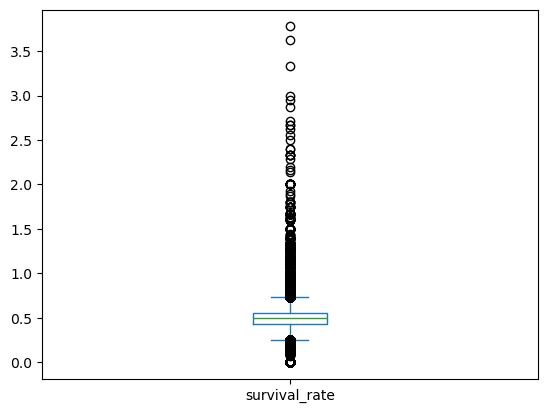

In [18]:
cleaned_df.survival_rate.plot.box()

It looks like we have some rows where survival rate is above 1, which would mean there's more old establishments than ones we started with. This may be due to error in surveying or due to the binning of our 1-5year group.

### Further Data Cleaning

In [19]:
cleaned_df.isnull().sum().sort_values(ascending = False)

estabs_exit_rate               81263
job_destruction_rate_deaths    81263
job_destruction_deaths         81263
estabs_exit                    81263
firmdeath_firms                80654
firmdeath_emp                  80654
firmdeath_estabs               80654
job_destruction_rate           73923
job_destruction                73923
job_destruction_continuers     73850
job_creation_continuers        73850
reallocation_rate              73801
job_creation_births            21372
job_creation_rate_births       21372
estabs_entry_rate              21372
estabs_entry                   21372
denom                           4776
net_job_creation                4776
net_job_creation_rate           4776
emp                             4654
job_creation_rate               4654
estabs_youngx                   4654
firms                           4654
job_creation                    4654
cutoff_year                        0
year_survived                      0
estabs_survived                    0
e

There is still a lot of null values in our dataset that we need to address. There is missing data due the different age groups. For example we can see that establishments/firms at age 0 don't contain any measures of establishment exit, establishment exit rate, job creation continuers, job desctruction, or firm deaths.

For this reason it likely makes sense to drop these columns entirely from our cleaned dataset. 

In [20]:
cleaned_df[cleaned_df.eagecoarse == 'a) 0'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 73568 entries, 0 to 220808
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   year_young                   73568 non-null  float64
 1   st                           73568 non-null  object 
 2   metro                        73568 non-null  object 
 3   sector                       73568 non-null  object 
 4   young_est                    73568 non-null  float64
 5   eagecoarse                   73568 non-null  object 
 6   firms                        69147 non-null  float64
 7   estabs_youngx                69147 non-null  float64
 8   emp                          69147 non-null  float64
 9   denom                        69147 non-null  float64
 10  estabs_entry                 69147 non-null  float64
 11  estabs_entry_rate            69147 non-null  object 
 12  estabs_exit                  0 non-null      float64
 13  estabs_exit_rate    

We can see that due to how the data is collected for establishments in year 0, we are missing data. The survey, for example, doesnt count establishments that both entered and exited in their opening year. For that reason estabs_exit, and estabs_exit_rate are all blank in is group. The same goes from job_destruction. There is no job loss since for establishments in year 0 since they would not exist in the first place (if they were created and lost in under a year)

In [21]:
cleaned_df[cleaned_df.eagecoarse == 'b) 1 to 5'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 75456 entries, 1 to 226471
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   year_young                   75456 non-null  float64
 1   st                           75456 non-null  object 
 2   metro                        75456 non-null  object 
 3   sector                       75456 non-null  object 
 4   young_est                    75456 non-null  float64
 5   eagecoarse                   75456 non-null  object 
 6   firms                        75223 non-null  float64
 7   estabs_youngx                75223 non-null  float64
 8   emp                          75223 non-null  float64
 9   denom                        75101 non-null  float64
 10  estabs_entry                 58505 non-null  float64
 11  estabs_entry_rate            58505 non-null  object 
 12  estabs_exit                  67761 non-null  float64
 13  estabs_exit_rate    

When establishments are in the 1-5 year category, we can see we don't have the same issue. In this case, we will drop columns where there is missing data for new establishments. 

In [22]:
columns = ['year_young', 'st', 'metro', 'sector', 'eagecoarse',
            'firms', 'estabs_youngx', 'emp', 'denom',  'job_creation',
            'net_job_creation', 'net_job_creation_rate', 'cutoff_year',
            'estabs_survived', 'estabs_youngy', 'survival_rate']

In [23]:
cleaned_df = cleaned_df[columns].copy()

In [24]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 149024 entries, 0 to 226471
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   year_young             149024 non-null  float64
 1   st                     149024 non-null  object 
 2   metro                  149024 non-null  object 
 3   sector                 149024 non-null  object 
 4   eagecoarse             149024 non-null  object 
 5   firms                  144370 non-null  float64
 6   estabs_youngx          144370 non-null  float64
 7   emp                    144370 non-null  float64
 8   denom                  144248 non-null  float64
 9   job_creation           144370 non-null  float64
 10  net_job_creation       144248 non-null  float64
 11  net_job_creation_rate  144248 non-null  object 
 12  cutoff_year            149024 non-null  float64
 13  estabs_survived        149024 non-null  float64
 14  estabs_youngy          149024 non-null  f

### Adding Derived Features

I'm going to add two derived features to this dataset (besides survival rate). Average Firm Size and Average Establishment Size. These will be calculated by dividing total employment in each group by total firms and total est.

In [25]:
cleaned_df['avg_firm_size'] = cleaned_df['emp']/cleaned_df['firms']
cleaned_df['avg_estab_size'] = cleaned_df['emp']/cleaned_df['estabs_youngx']

<Axes: >

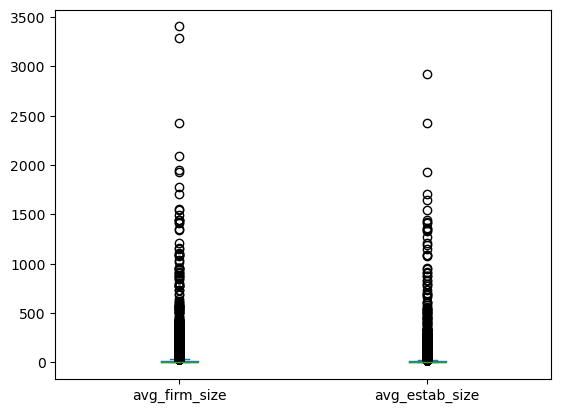

In [26]:
cleaned_df[['avg_firm_size','avg_estab_size']].plot.box()

A hypothesis for adding these two features is that larger firms and establishments could be more resillient to changes in market conditions. For example, if there's a recessiong, a larger establishment would be able to reduce it's labor force before closing etirely.

In [27]:
##Renaming columns for clarity

col_renames = {
                'year_young' : 'year',
                'st' : 'state', 
                'eagecoarse' : 'estab_age_group',
                'estabs_youngx' : 'estabs_count',
                'emp' : 'employed',
                'denom' : 'avg_employed',
                'cutoff_year' : 'year_aged', 
                'estabs_survived' : 'future_aged_estabs_ct',
                'estabs_youngy': 'tot_estabs_lt_six'
                }

cleaned_df.rename(columns = col_renames, inplace=True)
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 149024 entries, 0 to 226471
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   year                   149024 non-null  float64
 1   state                  149024 non-null  object 
 2   metro                  149024 non-null  object 
 3   sector                 149024 non-null  object 
 4   estab_age_group        149024 non-null  object 
 5   firms                  144370 non-null  float64
 6   estabs_count           144370 non-null  float64
 7   employed               144370 non-null  float64
 8   avg_employed           144248 non-null  float64
 9   job_creation           144370 non-null  float64
 10  net_job_creation       144248 non-null  float64
 11  net_job_creation_rate  144248 non-null  object 
 12  year_aged              149024 non-null  float64
 13  future_aged_estabs_ct  149024 non-null  float64
 14  tot_estabs_lt_six      149024 non-null  f

In [28]:
cleaned_df.isnull().sum()

year                        0
state                       0
metro                       0
sector                      0
estab_age_group             0
firms                    4654
estabs_count             4654
employed                 4654
avg_employed             4776
job_creation             4654
net_job_creation         4776
net_job_creation_rate    4776
year_aged                   0
future_aged_estabs_ct       0
tot_estabs_lt_six           0
survival_rate               0
avg_firm_size            6204
avg_estab_size           6204
dtype: int64

In [29]:
#dropping any rows that are missing values
cleaned_df = cleaned_df[cleaned_df.firms.notnull()]
cleaned_df = cleaned_df[cleaned_df.net_job_creation_rate.notnull()]
cleaned_df = cleaned_df[cleaned_df.avg_firm_size.notnull()]
cleaned_df.net_job_creation_rate = cleaned_df.net_job_creation_rate.astype('float')
cleaned_df.reset_index(drop=True, inplace = True)
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142820 entries, 0 to 142819
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   year                   142820 non-null  float64
 1   state                  142820 non-null  object 
 2   metro                  142820 non-null  object 
 3   sector                 142820 non-null  object 
 4   estab_age_group        142820 non-null  object 
 5   firms                  142820 non-null  float64
 6   estabs_count           142820 non-null  float64
 7   employed               142820 non-null  float64
 8   avg_employed           142820 non-null  float64
 9   job_creation           142820 non-null  float64
 10  net_job_creation       142820 non-null  float64
 11  net_job_creation_rate  142820 non-null  float64
 12  year_aged              142820 non-null  float64
 13  future_aged_estabs_ct  142820 non-null  float64
 14  tot_estabs_lt_six      142820 non-nu

### Assigning Binary Class from 'Survival Rate'

In [30]:
cleaned_df.survival_rate.describe()

count    142820.000000
mean          0.497153
std           0.124993
min           0.000000
25%           0.435185
50%           0.493213
75%           0.548780
max           3.333333
Name: survival_rate, dtype: float64

<Axes: >

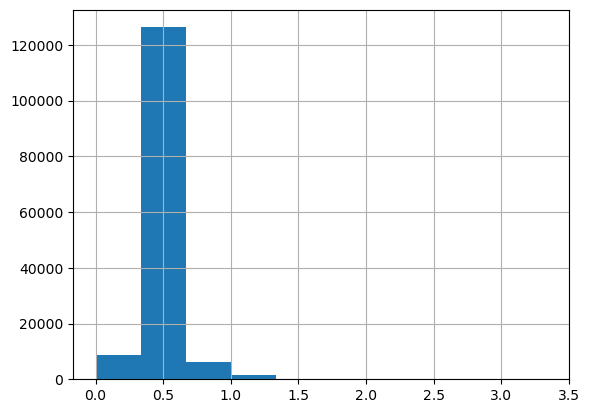

In [31]:
cleaned_df.survival_rate.hist()

It looks like our survival rate is pretty normally distributed around 50%. For this reason, we'll assign binary classes as follows:

- 1 (Likely to Survive): Groups whose 6+ year survival rate exceeds a survival rate of .5
- 0 (Not Likely to Survive): Groups whose 6+ year survival rate fall is .5 or lower.

<Axes: >

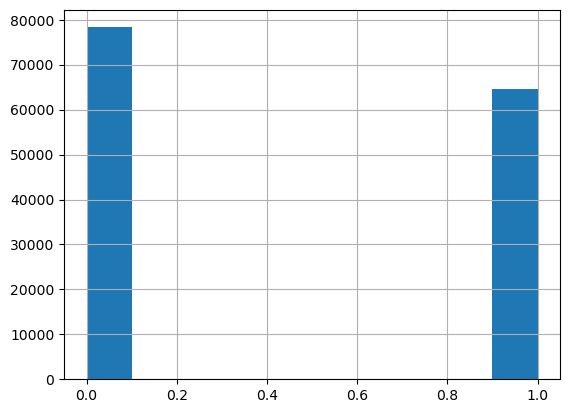

In [32]:
cleaned_df['survival_class'] = 0
cleaned_df.loc[cleaned_df.survival_rate > .5, 'survival_class'] = 1
cleaned_df.survival_class.hist()

We can see that the distribution of our binary variables are slightly unbalanced, but not to an unacceptable degree.

###

<Axes: >

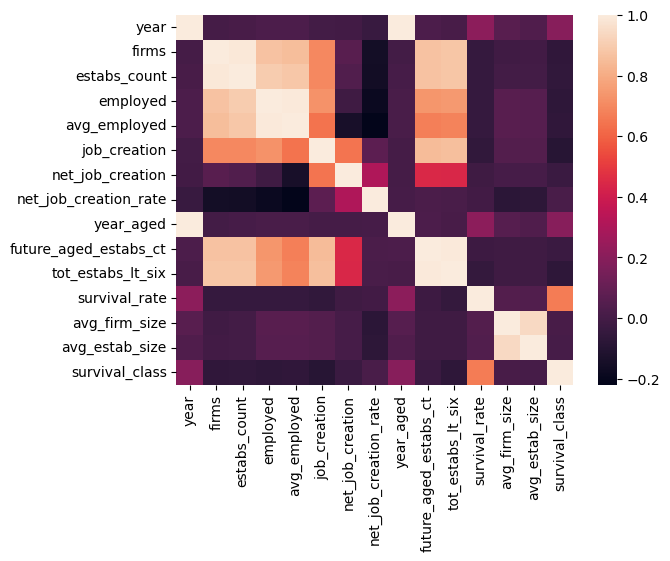

In [35]:
sns.heatmap(cleaned_df.corr(numeric_only=True))

The correlation matrix indicates that year seems to be the strongest numeric feature for predicting survivability

array([[<Axes: title={'center': 'year'}>,
        <Axes: title={'center': 'firms'}>,
        <Axes: title={'center': 'estabs_count'}>],
       [<Axes: title={'center': 'employed'}>,
        <Axes: title={'center': 'avg_employed'}>,
        <Axes: title={'center': 'job_creation'}>],
       [<Axes: title={'center': 'net_job_creation'}>,
        <Axes: title={'center': 'net_job_creation_rate'}>,
        <Axes: title={'center': 'year_aged'}>],
       [<Axes: title={'center': 'future_aged_estabs_ct'}>,
        <Axes: title={'center': 'tot_estabs_lt_six'}>,
        <Axes: title={'center': 'survival_rate'}>],
       [<Axes: title={'center': 'avg_firm_size'}>,
        <Axes: title={'center': 'avg_estab_size'}>,
        <Axes: title={'center': 'survival_class'}>]], dtype=object)

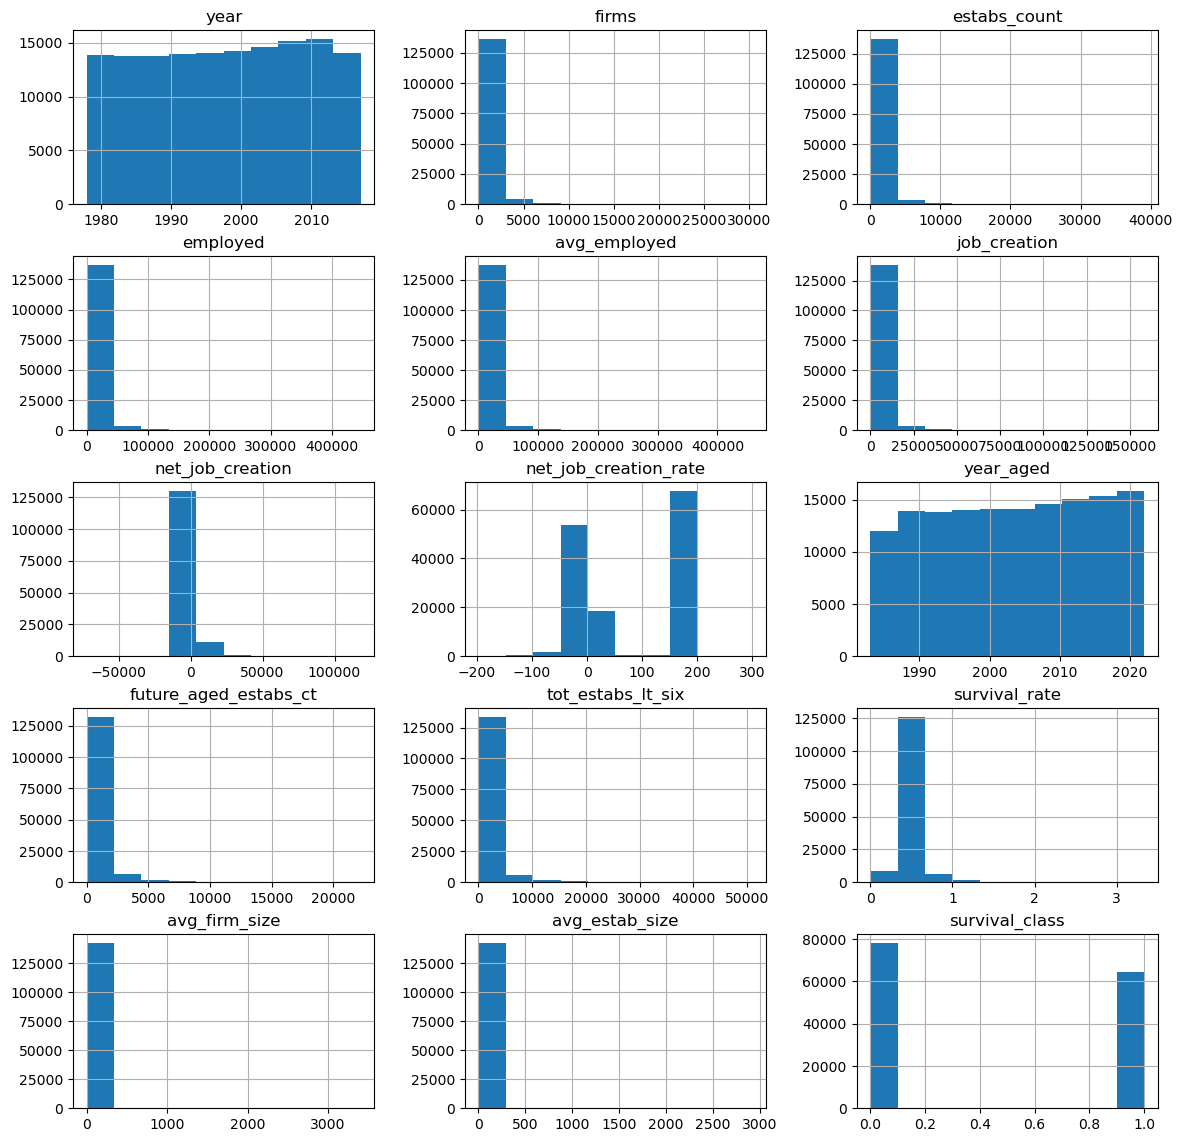

In [36]:
cleaned_df.hist(figsize=(14,14), layout=(5,3))

<Axes: >

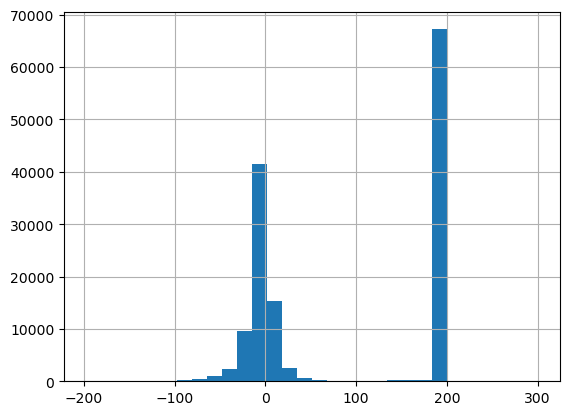

In [37]:
cleaned_df.net_job_creation_rate.hist(bins=30)

In [38]:
cleaned_df.net_job_creation_rate.value_counts()

net_job_creation_rate
 200.000    67190
 0.000        786
 160.000      110
 150.000       99
 180.000       91
            ...  
-53.450         1
-15.467         1
 11.329         1
-50.940         1
 58.380         1
Name: count, Length: 35520, dtype: int64

For the net job creation rate data, nearly half our data has a value of 200. This again can be traced back to how the job dynamic metrics work for establishments in year 0. There's no job destruction for establishments who are 0 years old. net_job_creation_rate is calculated by job creation rate minus job destruction rate. Since nearly half of our data is coded this way, it makes sense again to exclude this column from our final dataset.

### Issues with Data Leakage

We will to leave some additional features out of our final dataset, as they will pose a problem in our model due to data leakage. We don't want our model to 'see' any information about future performance of establishments during training, so we will remove `future_aged_estabs_ct`, `year_aged`, and `survival_rate`.


In [39]:
model_data = cleaned_df.drop(['net_job_creation_rate','future_aged_estabs_ct', 'year_aged', 'survival_rate'], axis=1).copy()

### Distribution of Categorical Columns

Let's review our categorical columns as well to see if there are any issues we need to take into account:

<Axes: ylabel='state'>

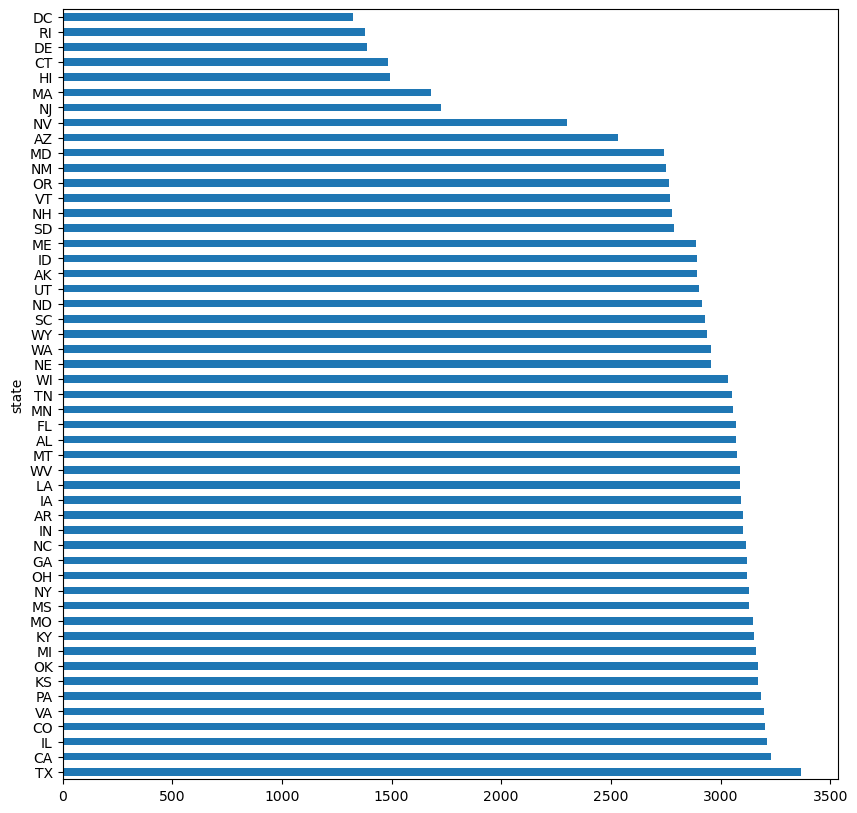

In [40]:
model_data.state.value_counts().plot(kind = 'barh', figsize = (10,10))

It seems like we have a pattern of having less data for smaller states like DC, Rhode Island, and New Jersey. This may be due to the limited amount of industries in metropolitan areas. For example, due to it's nature DC will not have a single establishment that is in the mining industry and is non-metropolitan.

<Axes: ylabel='sector'>

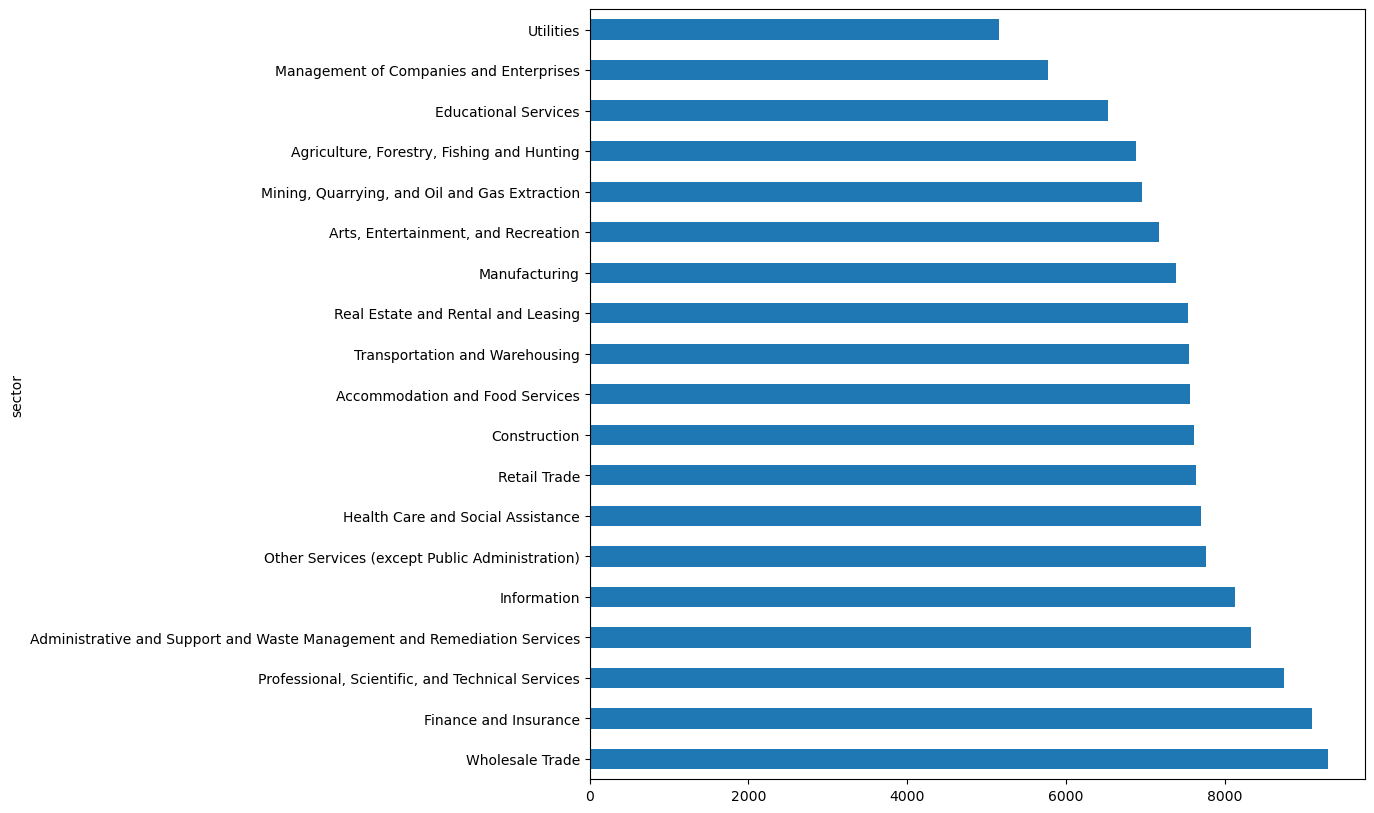

In [41]:
model_data.sector.value_counts().plot(kind = 'barh', figsize = (10,10))

<Axes: xlabel='metro'>

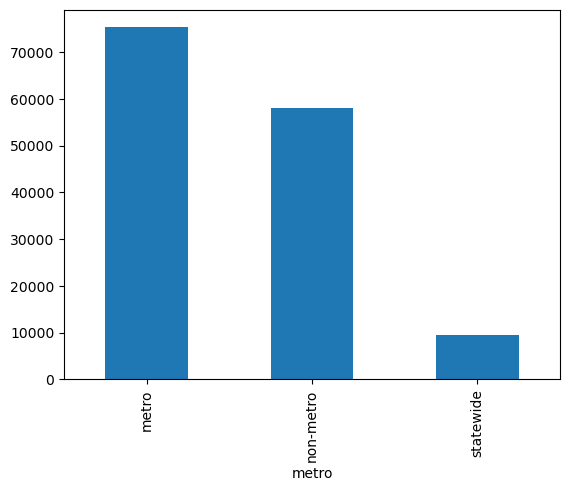

In [42]:
model_data.metro.value_counts().plot(kind = 'bar')

It looks the metropolitan class data may be a bit biased. There's very few establishments that are statewide overall.

Our dataset contains a lot of categorical values. We will plan to transform our categroical data using one-hot-encoding, however it will introduce a large dimensionality to our dataset, which we will need to consider when finding the right model to use.

### Feature Changes Accross Years

<Axes: xlabel='year', ylabel='survival_rate'>

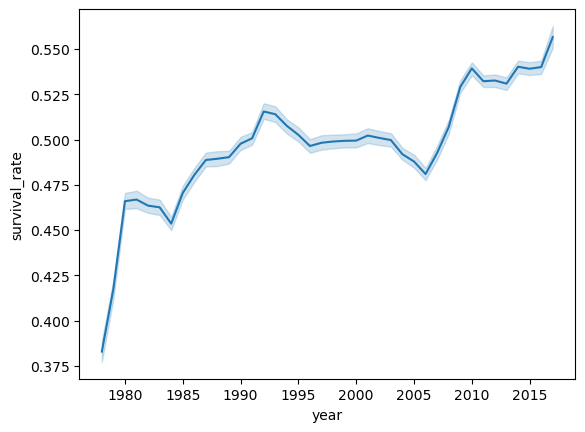

In [33]:
import seaborn as sns

sns.lineplot(cleaned_df, x='year', y='survival_rate')

<Axes: xlabel='year', ylabel='survival_rate'>

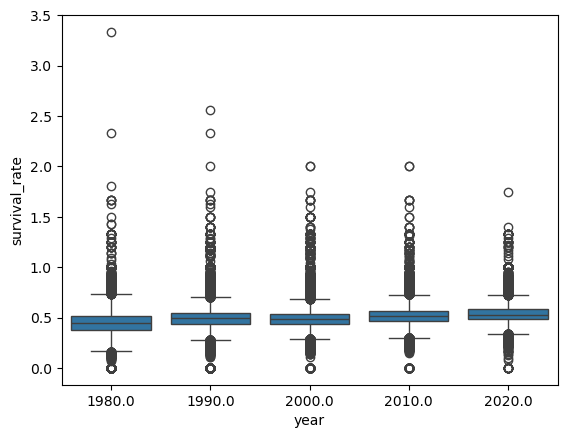

In [34]:
sns.boxplot(data=cleaned_df, x=cleaned_df['year'].round(-1), y='survival_rate')

<Axes: xlabel='year', ylabel='avg_estab_size'>

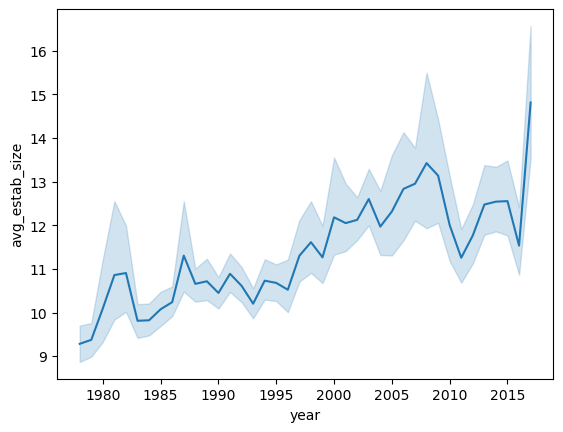

In [43]:
import seaborn as sns

sns.lineplot(data = model_data, x = 'year', y = 'avg_estab_size')

<Axes: xlabel='year', ylabel='job_creation'>

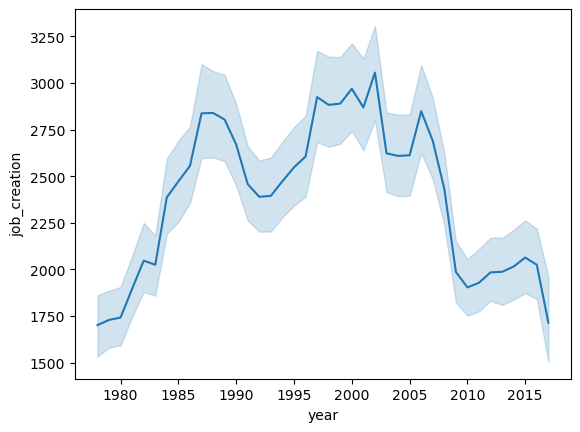

In [44]:
sns.lineplot(data = model_data, x = 'year', y = 'job_creation')

<Axes: xlabel='year', ylabel='net_job_creation'>

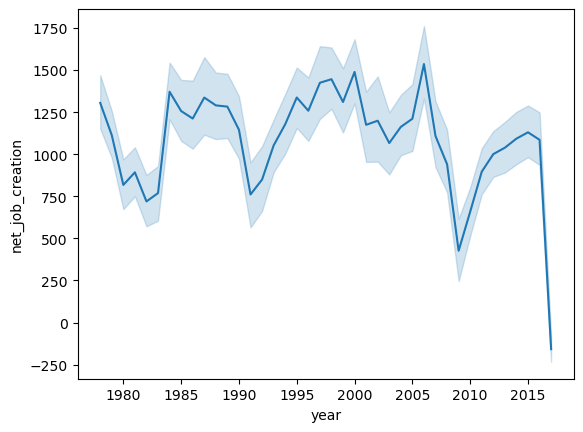

In [45]:
sns.lineplot(data = model_data, x = 'year', y = 'net_job_creation')

<Axes: xlabel='year', ylabel='estabs_count'>

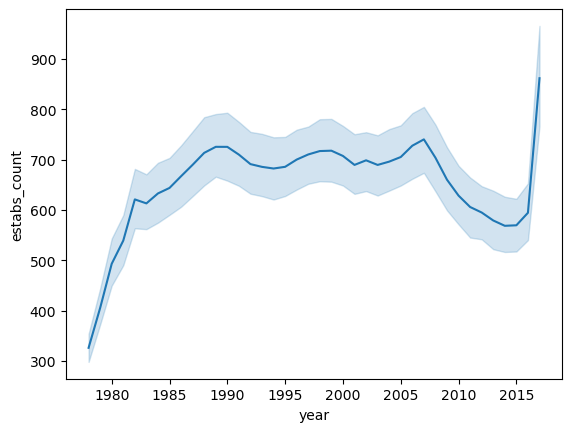

In [46]:
sns.lineplot(data = model_data, x = 'year', y = 'estabs_count')

2017 seems to have some extreme values. Let's explore further.

In [47]:
data_2017 = model_data[model_data.year == 2017].copy()
data_2017.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
year,2133.0,NaN,NaN,NaN,2017.0,0.0,2017.0,2017.0,2017.0,2017.0,2017.0
state,2133,51,OH,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN
metro,2133,3,metro,960,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sector,2133,19,"Professional, Scientific, and Technical Services",142,NaN,NaN,NaN,NaN,NaN,NaN,NaN
estab_age_group,2133,1,b) 1 to 5,2133,NaN,NaN,NaN,NaN,NaN,NaN,NaN
firms,2133.0,NaN,NaN,NaN,696.441632,1965.486814,3.0,20.0,84.0,439.0,29800.0
estabs_count,2133.0,NaN,NaN,NaN,861.447257,2382.317294,3.0,28.0,99.0,546.0,32989.0
employed,2133.0,NaN,NaN,NaN,10291.531646,30050.418544,4.0,221.0,924.0,6657.0,446678.0
avg_employed,2133.0,NaN,NaN,NaN,10372.791842,30240.993979,5.0,229.0,965.0,6795.0,458631.0
job_creation,2133.0,NaN,NaN,NaN,1714.865448,5235.952554,0.0,27.0,136.0,1020.0,76605.0


In [48]:
data_2016 = model_data[model_data.year == 2016].copy()
data_2016.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
year,3984.0,NaN,NaN,NaN,2016.0,0.0,2016.0,2016.0,2016.0,2016.0,2016.0
state,3984,51,OH,95,NaN,NaN,NaN,NaN,NaN,NaN,NaN
metro,3984,3,metro,1901,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sector,3984,19,"Professional, Scientific, and Technical Services",282,NaN,NaN,NaN,NaN,NaN,NaN,NaN
estab_age_group,3984,2,b) 1 to 5,2137,NaN,NaN,NaN,NaN,NaN,NaN,NaN
firms,3984.0,NaN,NaN,NaN,488.556978,1495.836482,3.0,15.0,56.0,296.25,29031.0
estabs_count,3984.0,NaN,NaN,NaN,594.198293,1796.961448,3.0,19.0,70.5,360.75,31977.0
employed,3984.0,NaN,NaN,NaN,6542.101155,22258.495207,3.0,123.0,591.0,3411.75,416892.0
avg_employed,3984.0,NaN,NaN,NaN,6001.181978,22117.538058,2.0,86.75,446.5,2536.0,427485.0
job_creation,3984.0,NaN,NaN,NaN,2025.005522,6098.893372,0.0,40.0,204.5,1334.25,118150.0


After reviewing our data, it looks like data from the year 2017 has only establishments in the 1-5 age group. For this reason, let's cut this year out of our data.

In [49]:
model_data = model_data[model_data.year <= 2016].copy()
model_data.reset_index(inplace = True, drop = True) 

### Cleaned Dataset Review

We now have a clean dataset we can use to begin training our model.

In [50]:
model_data.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
year,140687.0,NaN,NaN,NaN,1997.505825,11.322338,1978.0,1988.0,1998.0,2007.0,2016.0
state,140687,51,TX,3314,NaN,NaN,NaN,NaN,NaN,NaN,NaN
metro,140687,3,metro,74380,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sector,140687,19,Wholesale Trade,9156,NaN,NaN,NaN,NaN,NaN,NaN,NaN
estab_age_group,140687,2,b) 1 to 5,72694,NaN,NaN,NaN,NaN,NaN,NaN,NaN
firms,140687.0,NaN,NaN,NaN,554.052521,1518.346015,3.0,21.0,88.0,396.0,30378.0
estabs_count,140687.0,NaN,NaN,NaN,647.358434,1808.739004,3.0,24.0,97.0,446.0,39086.0
employed,140687.0,NaN,NaN,NaN,7224.893992,22144.175803,3.0,155.0,772.0,4383.0,440700.0
avg_employed,140687.0,NaN,NaN,NaN,6672.548103,22368.898177,2.0,106.0,574.0,3319.0,442830.0
job_creation,140687.0,NaN,NaN,NaN,2401.784586,6326.536097,0.0,63.0,305.0,1765.5,158254.0


In [51]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140687 entries, 0 to 140686
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   year               140687 non-null  float64
 1   state              140687 non-null  object 
 2   metro              140687 non-null  object 
 3   sector             140687 non-null  object 
 4   estab_age_group    140687 non-null  object 
 5   firms              140687 non-null  float64
 6   estabs_count       140687 non-null  float64
 7   employed           140687 non-null  float64
 8   avg_employed       140687 non-null  float64
 9   job_creation       140687 non-null  float64
 10  net_job_creation   140687 non-null  float64
 11  tot_estabs_lt_six  140687 non-null  float64
 12  avg_firm_size      140687 non-null  float64
 13  avg_estab_size     140687 non-null  float64
 14  survival_class     140687 non-null  int64  
dtypes: float64(10), int64(1), object(4)
memory usage: 1

## Modelling

Now that we have a cleaned dataset to work with, we can begin tuning our model.

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

X = model_data.drop('survival_class', axis=1)
y = model_data.survival_class

categorical_columns = []
numeric_columns = []

for col in X.columns:
    if X[col].dtype.kind == 'O':
        categorical_columns.append(col)
    else:
        numeric_columns.append(col)

print(categorical_columns)
print(numeric_columns)

['state', 'metro', 'sector', 'estab_age_group']
['year', 'firms', 'estabs_count', 'employed', 'avg_employed', 'job_creation', 'net_job_creation', 'tot_estabs_lt_six', 'avg_firm_size', 'avg_estab_size']


In [53]:
#Creating preprocessing transformer, categorical columns go through one-hot-encoding
#numeric columns are scaled using StandardScaler
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output = False)
numeric_transformer = StandardScaler()  

preprocessing = ColumnTransformer(transformers=[('categorical', categorical_transformer, categorical_columns),
                                                ('numeric', numeric_transformer, numeric_columns)])



### Train-Test Split with Time Series Data

Since our dataset spans accross years, we need to be careful in the way we do train-test split. Since we want our model to predict future outcomes, it's important to maintain order when splitting our dataset. Instead of shuffling future data into our training data, we should train our model on earlier years, and test on later years.

In [54]:
#Sorting data by year ascending
model_data.sort_values(by = 'year',inplace=True)
model_data.reset_index(drop = True, inplace = True)
model_data.iloc[0:int(model_data.shape[0]*.8)].describe()

,year,firms,estabs_count,employed,avg_employed,job_creation,net_job_creation,tot_estabs_lt_six,avg_firm_size,avg_estab_size,survival_class
count,112549.000000,112549.000000,112549.000000,112549.000000,112549.000000,112549.000000,112549.000000,112549.000000,112549.000000,112549.000000,112549.000000
mean,1993.654470,571.972305,662.707905,7414.083599,6844.389324,2510.578246,1142.886529,1325.056375,13.396674,11.186971,0.400999
std,9.219096,1535.331606,1823.418973,22406.930821,22681.694786,6497.654053,5727.396130,3203.430334,32.898614,25.392828,0.490103
min,1978.000000,3.000000,3.000000,3.000000,2.000000,0.000000,-72210.000000,3.000000,1.000000,1.000000,0.000000
25%,1986.000000,23.000000,26.000000,163.000000,111.000000,69.000000,-46.000000,62.000000,4.621100,4.375000,0.000000
50%,1994.000000,96.000000,104.000000,815.000000,601.000000,330.000000,47.000000,238.000000,7.833333,7.166667,0.000000
75%,2002.000000,418.000000,467.000000,4610.000000,3491.000000,1877.000000,542.000000,1021.000000,14.444444,12.500000,1.000000
max,2009.000000,30378.000000,39086.000000,440700.000000,442830.000000,158254.000000,117598.000000,51023.000000,3405.666667,2919.142857,1.000000


In [55]:
model_data.iloc[int(model_data.shape[0]*.8):].describe()

,year,firms,estabs_count,employed,avg_employed,job_creation,net_job_creation,tot_estabs_lt_six,avg_firm_size,avg_estab_size,survival_class
count,28138.000000,28138.000000,28138.000000,28138.000000,28138.000000,28138.000000,28138.000000,28138.000000,28138.000000,28138.000000,28138.000000
mean,2012.910832,482.375293,585.962186,6468.155732,5985.201542,1966.621544,969.614649,1171.328417,15.699932,12.008001,0.637181
std,2.087908,1446.222733,1747.472783,21043.811374,21057.732959,5568.838879,4753.726233,3039.475421,32.525520,25.087935,0.480822
min,2009.000000,3.000000,3.000000,3.000000,2.000000,0.000000,-40306.000000,3.000000,1.000000,1.000000,0.000000
25%,2011.000000,15.000000,19.000000,126.000000,87.000000,46.000000,-22.750000,47.000000,4.806085,4.335792,0.000000
50%,2013.000000,62.000000,72.000000,628.000000,477.000000,221.000000,41.000000,168.000000,8.818813,7.505265,1.000000
75%,2015.000000,305.000000,368.000000,3509.500000,2625.500000,1389.000000,418.000000,835.000000,16.300000,13.142857,1.000000
max,2016.000000,29031.000000,31977.000000,416892.000000,427485.000000,118150.000000,118150.000000,43081.000000,1425.400000,1425.400000,1.000000


When using the standard 80/20 train test split, we can see that 80% of our data is for years 1978-2010, and the remaining 20% is for 2010-2017. We'll set a cutoff year at 2010 and split our groups accordingly. 

In [56]:
X_train = model_data[model_data.year <= 2011].drop('survival_class', axis=1)
y_train = model_data[model_data.year <= 2011].survival_class

X_test = model_data[model_data.year > 2011].drop('survival_class', axis=1)
y_test = model_data[model_data.year > 2011].survival_class

In [57]:
print(f'training data share: {round(X_train.shape[0]/model_data.shape[0],2)}')
print(f'test data share: {round(X_test.shape[0]/model_data.shape[0],2)}')

training data share: 0.86
test data share: 0.14


We're including all years from 2010 in the test data, so there is a slightly higher share of test data to training data than the usual 80/20 split.

### Model Testing

Next let's pick out some models to train. Let's try: 

- Random Forest Classifier
- Support Vector Classifier
- Logistic Regression
- K-Nearest Neighbors Classifier
- Gradiant Boosting Classifier
- Quadratic Discriminant Analysis (QDA)

In [58]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import datetime


#defining a helper function
def test_model(name, model):
    start_time = datetime.datetime.now()
    print(f'----------------------------------- Evaluating {name} -----------------------------------')
    print(f'Started training at {start_time}')
    model_pipeline = Pipeline([('preprocessing', preprocessing),
                               (name, model)])
    trained_model = model_pipeline.fit(X_train, y_train)
    print(f'Done. Training Time Elapsed: {datetime.datetime.now() - start_time} \n')
    print('Making predictions...')
    prediction = trained_model.predict(X_train)
    print("Confusion Matrix Results for Training:\n")
    print(confusion_matrix(y_train,prediction))
    print("Classification Report Restults for Training:\n")
    print(classification_report(y_train, prediction))    
    prediction = trained_model.predict(X_test)
    print("Confusion Matrix Results for Testing:\n")
    print(confusion_matrix(y_test,prediction))
    print("Classification Report Restults for Testing:\n")
    print(classification_report(y_test, prediction))
    print('==========================================================================================')

models = {'Random Forest Classifier' : RandomForestClassifier(random_state = 2), 
          'SVC' : SVC(random_state = 2),
          'Logistic Regressor' : LogisticRegression(max_iter = 2000, random_state = 2),
          'K Neighbors Classifier' : KNeighborsClassifier(),
          'QDA' : QuadraticDiscriminantAnalysis(),
          'Gradient Boost' : GradientBoostingClassifier(random_state = 2)
         }

for name, model in models.items():
          test_model(name,model)
    

----------------------------------- Evaluating Random Forest Classifier -----------------------------------
Started training at 2025-05-11 20:34:23.739533
Done. Training Time Elapsed: 0:00:39.912672 

Making predictions...
Confusion Matrix Results for Training:

[[70545     0]
 [    1 50528]]
Classification Report Restults for Training:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     70545
           1       1.00      1.00      1.00     50529

    accuracy                           1.00    121074
   macro avg       1.00      1.00      1.00    121074
weighted avg       1.00      1.00      1.00    121074

Confusion Matrix Results for Testing:

[[4199 2882]
 [3107 9425]]
Classification Report Restults for Testing:

              precision    recall  f1-score   support

           0       0.57      0.59      0.58      7081
           1       0.77      0.75      0.76     12532

    accuracy                           0.69     19613
   m

It looks like the most accurate model after the first round of training was the Random Forest Classifier with a test accuracy of .69. It's also important to note that the accuracy on the training data was 1, which suggests our model could likely improve by reducing bias. 

### Tuning the Model

Let's move forward with tuning our Random Forest Classifier. I'm interested in adjusting the following to see how it impacts our results:

1) Adjusting the years in the training data
    - it could be the case that we're including too much 'old data' for training.
    - The U.S. Economy fundamentally changed from 1978-2016, and the old indicators may not be useful in predicting modern trends.
2) Reduce overfitting by adjusting hyperparameters
3) Cross-validating our model

### Adjusting Timespan for Training

Let's go back and reduce the number of years in our training set. Remember, we're currently predicting longevity for establishments from 2012-2016. Let's see if our accuracy improves by dropping years 1978-1990 from our training set. 

In [59]:
X_train = model_data[(model_data.year > 1990) & (model_data.year <= 2011)].drop('survival_class', axis=1)
y_train = model_data[(model_data.year > 1990) & (model_data.year <= 2011)].survival_class

X_test = model_data[model_data.year > 2011].drop('survival_class', axis=1)
y_test = model_data[model_data.year > 2011].survival_class

In [60]:
print(f'training data share: {round(X_train.shape[0]/model_data[model_data.year > 1990].shape[0],2)}')
print(f'test data share: {round(X_test.shape[0]/model_data[model_data.year > 1990].shape[0],2)}')

training data share: 0.8
test data share: 0.2


In [61]:
test_model('rfc', RandomForestClassifier(random_state = 2))

----------------------------------- Evaluating rfc -----------------------------------
Started training at 2025-05-11 21:21:49.318759
Done. Training Time Elapsed: 0:00:24.477973 

Making predictions...
Confusion Matrix Results for Training:

[[41036     0]
 [    0 35193]]
Classification Report Restults for Training:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     41036
           1       1.00      1.00      1.00     35193

    accuracy                           1.00     76229
   macro avg       1.00      1.00      1.00     76229
weighted avg       1.00      1.00      1.00     76229

Confusion Matrix Results for Testing:

[[4063 3018]
 [3029 9503]]
Classification Report Restults for Testing:

              precision    recall  f1-score   support

           0       0.57      0.57      0.57      7081
           1       0.76      0.76      0.76     12532

    accuracy                           0.69     19613
   macro avg       0.67  

The answer is no, it doesn't appear that reducing the training years has improved our results. Let's go use the original data split.

In [62]:
X_train = model_data[model_data.year <= 2011].drop('survival_class', axis=1)
y_train = model_data[model_data.year <= 2011].survival_class

X_test = model_data[model_data.year > 2011].drop('survival_class', axis=1)
y_test = model_data[model_data.year > 2011].survival_class

### Hyperparameter Tuning

Let's train our Random Forest Classifier again.

In [63]:
rfc_pipeline = Pipeline([('preprocessing', preprocessing),
                         ('rfc', RandomForestClassifier(random_state = 2))])

forest = rfc_pipeline.fit(X_train, y_train)


Let's review which features are the most important for the model

In [64]:
features = forest['preprocessing'].get_feature_names_out()
scores = forest['rfc'].feature_importances_
feature_scores = pd.DataFrame({'features' : features, 'scores' : scores})
pd.set_option('display.max_rows', 81)
sorted = feature_scores.sort_values(by = 'scores', ascending = False)
sorted.reset_index(inplace = True, drop = True)
sorted

,features,scores
0,numeric__year,0.104062
1,numeric__tot_estabs_lt_six,0.079933
2,numeric__avg_estab_size,0.065019
3,numeric__avg_firm_size,0.064671
4,numeric__net_job_creation,0.061819
5,numeric__job_creation,0.061647
6,numeric__avg_employed,0.057508
7,numeric__employed,0.057148
8,numeric__estabs_count,0.056669
9,numeric__firms,0.056506


<Axes: xlabel='# of Top Features', ylabel='Feature Importance'>

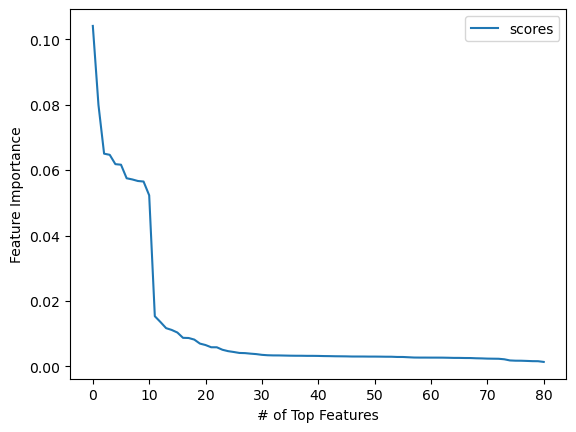

In [65]:
sorted.plot(xlabel = '# of Top Features', ylabel = 'Feature Importance')

It appears that there's a sharp drop-off of feature importance after the first 10 features. Let's factor this into our hyper-parameter tuning

### Cross-Validation with GridSearchCV
Let's try to tune our RandomForestClassifier model using GridSearchCV. Again since we're using time series data, for the cv we will use the TimeSeriesSplit as the cross-validator. This split will keep training/validation data in sequential order according to year.

In [66]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

cv = TimeSeriesSplit(n_splits = 2)


params = {
            'rfc__n_estimators': [100, 200],
            'rfc__max_depth': [5, 10, 20],
            'rfc__min_samples_split': [2, 3],
            'rfc__max_features': [5, 10, 'sqrt', 'log2']
         }

cv_results = GridSearchCV(rfc_pipeline, param_grid = params, cv = cv)
start_time = datetime.datetime.now()
print(f'Started Cross Validation at {start_time}')
cv_results.fit(X_train, y_train)
print(f'Done. Training Time Elapsed: {datetime.datetime.now() - start_time}')
print(cv_results.best_params_)


Started Cross Validation at 2025-05-11 21:22:58.543826
Done. Training Time Elapsed: 0:22:42.473747
{'rfc__max_depth': 20, 'rfc__max_features': 10, 'rfc__min_samples_split': 2, 'rfc__n_estimators': 200}


### Tuned Model Evaluation

Let's take the best parameters as discovered in the previous section and retrain the model on the entire training set.

In [67]:
test_model('rfc', RandomForestClassifier(max_depth = 20,
                                         max_features = 10,
                                         min_samples_split = 3,
                                         n_estimators = 200,
                                         random_state=2))

----------------------------------- Evaluating rfc -----------------------------------
Started training at 2025-05-11 21:45:41.027223
Done. Training Time Elapsed: 0:01:14.013171 

Making predictions...
Confusion Matrix Results for Training:

[[66676  3869]
 [14233 36296]]
Classification Report Restults for Training:

              precision    recall  f1-score   support

           0       0.82      0.95      0.88     70545
           1       0.90      0.72      0.80     50529

    accuracy                           0.85    121074
   macro avg       0.86      0.83      0.84    121074
weighted avg       0.86      0.85      0.85    121074

Confusion Matrix Results for Testing:

[[3884 3197]
 [2792 9740]]
Classification Report Restults for Testing:

              precision    recall  f1-score   support

           0       0.58      0.55      0.56      7081
           1       0.75      0.78      0.76     12532

    accuracy                           0.69     19613
   macro avg       0.67  

Despite reducing bias in our model, it appears that it had no impact on the prediction capacity of our model when testing.

### Conclusion and Next Steps

The Random Forest Classifier achieved the highest accuracy among all models tested, but performance plateaued around 70% even after attempts at tuning. Although not perfect, this suggests that establishment survival appears moderately predictable when macroeconomic, geographic, and industry-specific information is available. 

A large portion of the original dataset was removed due to missing values, which may have reduced model effectiveness. The derived features we added appeared to be useful for prediction. The dataset’s time-series nature introduced additional complexity, and there could be futher exploration of temporal drift. Better data quality and inclusion of more relevant economic indicators could improve future model performance.

For next steps in this project, I would likely start with revising the method used to calculate survival rate and rethinking the classification threshold. For example, setting a higher cutoff threshold (.7 compared to .5), or adding a third class, could establish clearer distinctions between classes. 

Another improvement to the methodology could be to take the average of the counts in the 6 to 10 age range accross future years, insteadof relying on a single cut-off year, which better aligns with the binned age group structure.

I think our training data could be vastly improved. The weak predictability accross models indicates that we're missing a clear indicator of survivability in our dataset. It's possible a strong indicator was removed in the data cleaning process, as we did trim a majority of the data from the initial set. A next step could be imputing missing values with group means rather than dropping entire columns. It's also important to consider that the original data quality may not be the best, as it relys on surveys of businesses, which aren't always reliable.

Adding additional derived features (that make sense in context) could improve our dataset. The derived features like average firm size and average establishment size were among the most important, which suggests that adding more engineered features could be beneficial. Another next step could be adding a weighted feature that adds more weight to recent years during training, so that the model can better predict the present. 

Another next step would be to continue testing more classification models. This along with tuning could reveal better-performing algorithms that we did not evaluate in the scope of this project.

Although our final model provided only moderate predictive capacity, we did discover that attempting to predict business establishment survivability is possible, and that it could serve as a useful tool to mitegate risk for business owners. 